# Identifying & Quantifying Missing Weather Data

Load in required packages:

In [1363]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import xarray as xr
import datetime
import time 
from timezonefinder import TimezoneFinder
import pytz

Read in temperature, precip, RH & solar radiation data:

In [1364]:
# these are loading the updated files generated through a more streamlined process
df_temp = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/temp_all.csv', index_col= 0)
df_rh = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/rh_all.csv', index_col= 0)
df_precip = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/precip_all.csv', index_col= 0)
df_solrad = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/backup/solrad_all.csv', index_col= 0)

# processing solar radiation data to only include growing season
df_solrad = df_solrad.reindex(df_temp.index)
print(df_temp.shape)
print(df_rh.shape)
print(df_precip.shape)
print(df_solrad.shape)

(262968, 237)
(262968, 237)
(262968, 237)
(262968, 237)


In [1365]:
# saving the updated solar radiation data
df_solrad.to_csv('/home/disk/eos8/ach315/upscale/weadata/solrad_all.csv')

Putting all the weather data into xarray

In [1366]:
timepoints = pd.to_datetime(df_temp.index)
sites = df_temp.columns

ds_weadata = xr.Dataset({"temperature": (["time", "loc"], df_temp),
                         "precipitation": (["time", "loc"], df_precip),
                         "relhumidity": (["time", "loc"], df_rh),
                         "solrad": (["time", "loc"], df_solrad)},
                        coords= {"time": timepoints,
                                 "loc": sites})

ds_weadata

<xarray.Dataset>
Dimensions:        (loc: 237, time: 262968)
Coordinates:
  * time           (time) datetime64[ns] 1961-01-01 1961-01-01T01:00:00 ...
  * loc            (loc) object '03103' '03812' '03813' '03820' '03822' ...
Data variables:
    temperature    (time, loc) float64 nan 3.3 14.4 9.4 11.7 9.4 nan nan 6.1 ...
    precipitation  (time, loc) float64 nan nan 109.0 48.0 0.0 13.0 nan nan ...
    relhumidity    (time, loc) float64 nan 0.892 0.9677 0.9665 0.9288 0.9665 ...
    solrad         (time, loc) float64 nan 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...

In [5]:
# JH 190910: *** Depricated Code ***
# these are loading the old weather files that are now in backup
df_temp = pd.read_csv("/home/disk/eos8/ach315/upscale/weadata/backup/temp_all.csv", index_col= 0)
df_precip = pd.read_csv("/home/disk/eos8/ach315/upscale/weadata/backup/precip_all.csv", index_col= 0)
df_rh = pd.read_csv("/home/disk/eos8/ach315/upscale/weadata/backup/rh_all.csv", index_col= 0)
df_solrad = pd.read_csv("/home/disk/eos8/ach315/upscale/weadata/backup/solrad_all.csv", index_col= 0)

### Step 1. Figure out site-years that can be gap-filled

In [6]:
#--- Setting up variables
# variable input for loop

# weather datasets to process
datasets = list([df_temp, df_rh, df_precip, df_solrad]) # df_rh is based off df_temp, so no need to evaluate 

# final lists to store processed output
finalist = list([[], [], [], []]) # order: [0]-temp, [1]-precip, [2]-solrad

# years
years = np.arange(1961, 1991)

# growing season
growseason_start = '-04-01 00:00:00' # *** maybe want to change this to earlier, -03-01 00:00:00
growseason_end = '-10-31 23:00:00'

# critical hrs of missing data
crit_hrs = 1

In [600]:
#--- Loop
# looking through the temp, precip & solrad dataset to pick out usable site-years

for i in np.arange(len(datasets)):
    dataset = datasets[i]
    siteyears_all = list()
    sites = dataset.columns
    
    for j in years:
        start_time = str(j) + growseason_start
        end_time = str(j) + growseason_end
        siteyears = list()
        
        for k in sites:
            df = dataset.loc[start_time:end_time, k] 
            df = pd.DataFrame(df)
            df['group'] = df.notnull().astype(int) # df.notnull() returns TRUE or FALSE, 
                                                   # .astype(int) turns TRUE into 1, and FALSE into 0
            df['group'] = df.group.cumsum() # calculating cumulative sum 
            df = df[df.iloc[:,0].isnull()] # selecting out individual timesteps that have missing data
            df['count'] = df.groupby('group')['group'].transform('size') # counts the number of consecutive NANs 
            df = df.drop_duplicates('group')
            
            if df[df['count'] > crit_hrs].shape[0] == 0:
                use_siteyear = str(j) + '_' + str(k)
                siteyears.append(use_siteyear) # only record site-years that have fewer consecutive NANs than the critical value set
        
        siteyears_all.extend(siteyears)
    
    finalist[i] = siteyears_all


### Step 2. Compare usable site-years for temp  & precip and find the common year-sites

In [601]:
yearsites_temp = finalist[0]
yearsites_rh = finalist[1]
yearsites_precip = finalist[2]
yearsites_solrad = finalist[3]

print('temp:', len(yearsites_temp))
print('precip:', len(yearsites_precip))
print('solrad:', len(yearsites_solrad))

yearsites = list(set(yearsites_temp) & set(yearsites_rh))
yearsites = list(set(yearsites) & set(yearsites_precip))
yearsites = list(set(yearsites) & set(yearsites_solrad))

yearsites.sort()

print('overlapping siteyears:', len(yearsites))

temp: 2838
precip: 2254
solrad: 7097
overlapping siteyears: 2125


In [561]:
#crithrs_0 = len(yearsites)
#crithrs_1 = len(yearsites)
#crithrs_2 = len(yearsites)
#crithrs_3 = len(yearsites)

### Step 3. Visualize output

<BarContainer object of 4 artists>

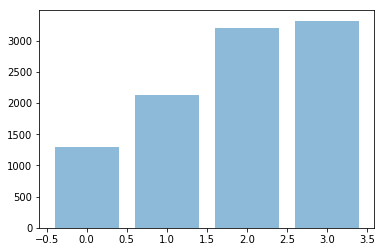

In [562]:
x = [0,1,2,3]
width =  [crithrs_0, crithrs_1, crithrs_2, crithrs_3]
plt.bar(x, width, alpha=0.5)

### Step 4. Parse out the year-sites into a dataframe that has usable year as a column & site as a column 

In [603]:
years = list()
sites = list()

for i in range(len(yearsites)):
    year = yearsites[i][0:4]
    years.append(year)
    site = yearsites[i][5:10]
    sites.append(site)

df_yearsites = pd.DataFrame({'site': sites, 'year': years}, 
                            columns=['site', 'year'])
df_yearsites = df_yearsites.sort_values(['site', 'year'])
final_sites = list(set(df_yearsites.site))

In [604]:
#df_yearsites.to_csv('../weadata/site_year_crithr1.csv')

In [299]:
numofyears = list()

for i in final_sites:
    years = len(df_yearsites[df_yearsites["site"] == i])
    numofyears.append(years)
    
df_numofyears = pd.DataFrame({"site": final_sites,
                              "years": numofyears})
df_numofyears = df_numofyears.sort_values(["site"])
df_numofyears = df_numofyears.reset_index().iloc[:, 1:3]

In [139]:
#df_numofyears.to_csv("../weadata/site_years.csv")

### Step 5. Select for subset dataset to include only valid (can be gap-filled) weather data

Read in required files:

In [9]:
siteyear = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/site_year_crithr1.csv', dtype="str")
siteyear = siteyear.drop(siteyear.columns[0], axis=1)
print(siteyear.shape)
siteyear.head()

(2125, 2)


,site,year
0,03103,1964
1,03103,1988
2,03812,1973
3,03812,1975
4,03812,1979


Read in individual weather data files and merge them into long form data frame:

In [50]:
# 190923: still thinking whether the code below in this step 5 section is necessary now

filelist = ['temp_all.csv', 'precip_all.csv', 'rh_all.csv', 'solrad_all.csv']
weavars = ['temp', 'precip', 'rh', 'solrad']
filenums = len(filelist)
dfs = [[],[],[],[]]
sites = sorted(list(set(siteyear.site)))
grow_months = [5,6,7,8,9,10]


for i in range(filenums):
    dfs[i] = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/' + filelist[i], index_col=0)
    dfs[i].index = pd.to_datetime(dfs[i].index) # converting index timepoint into datetimeindex
    dfs[i] = dfs[i][dfs[i].index.month.isin(grow_months)] # selecting only the growing season timepoints
    dfs[i] = dfs[i].filter(items=sites, axis=1) # selcting only the valid sites
    dfs[i]["date"] = dfs[i].index # creating another column that stores datetimeindex info, for melting purpose
    dfs[i] = pd.melt(dfs[i], id_vars="date", var_name="sites", value_name=weavars[i])

df = pd.merge(dfs[0], dfs[1])
df = pd.merge(df, dfs[2])
df = pd.merge(df, dfs[3])    

df.index = pd.to_datetime(df.date)
df = df.iloc[:, 1:]
df.head()

,sites,temp,precip,rh,solrad
date,,,,,
1961-05-01 00:00:00,03103,NaN,NaN,NaN,NaN
1961-05-01 01:00:00,03103,NaN,NaN,NaN,NaN
1961-05-01 02:00:00,03103,NaN,NaN,NaN,NaN
1961-05-01 03:00:00,03103,NaN,NaN,NaN,NaN
1961-05-01 04:00:00,03103,NaN,NaN,NaN,NaN


Selecting for valid site & years:

In [ ]:
valid_siteyears = siteyear.shape[0]
frames = []

for i in range(valid_siteyears):
    dfi = df[df.index.year == int(siteyear.year[i])]
    dfi = dfi[dfi.sites == siteyear.site[i]]
    frames.append(dfi)
#    print(len(frames)) # since this code takes time to run, 
                       # this helps to see where in the process it is

df_valid = pd.concat(frames)

Saving valid weather data frame into .csv:

In [52]:
print(df_valid.head())
print(df_valid.tail())
df_valid.to_csv("/home/disk/eos8/ach315/upscale/weadata/weadata.csv")

                     sites  temp  precip        rh  solrad
date                                                      
1964-05-01 00:00:00  03103   9.4     0.0  0.605071     0.0
1964-05-01 01:00:00  03103   5.6    15.0  0.850413     0.0
1964-05-01 02:00:00  03103   4.4     0.0  0.925122     0.0
1964-05-01 03:00:00  03103   3.3     0.0  0.924547     0.0
1964-05-01 04:00:00  03103   2.8     0.0  0.924283     0.0
                     sites  temp  precip        rh  solrad
date                                                      
1990-10-31 19:00:00  94910  21.1     0.0  0.543996     0.0
1990-10-31 20:00:00  94910  22.8     0.0  0.470004     0.0
1990-10-31 21:00:00  94910  23.3     0.0  0.440605     0.0
1990-10-31 22:00:00  94910  22.8     0.0  0.454449     0.0
1990-10-31 23:00:00  94910  19.4     0.0  0.562429     0.0


### Step 6: Compile and gap-fill usable site-years data into individual weather data files

In [660]:
#JH191030: code is only for 'control' maizsim weather input at the moment

In [1263]:
# time zone finder
def find_zone(site):
    """
    find time zone for specific sites
    """
    lat = float(siteinfo[siteinfo.site == site].lat)
    lon = float(siteinfo[siteinfo.site == site].lon) * -1
    tf = TimezoneFinder()    
    zone = tf.timezone_at(lng=lon, lat=lat)
    return zone

In [1262]:
# 200108JH: utc conversion second try!

def utc_to_local(times, zone):
    """
    convert list of utc timestamps into local time
    """
    times = times.to_pydatetime() # convert from pd.DatetimeIndex into python datetime format
    utc = pytz.timezone('UTC') # setting up the UTC timezone, requires package 'pytz'
    local_datetime = list()
    
    for time in times:
        utctime = utc.localize(time) # adding UTC timezone to datetime
        localtime = utctime.astimezone(pytz.timezone(zone)) 
        datetime = pd.to_datetime(localtime)
        local_datetime.append(datetime)
        
    return local_datetime

In [1370]:
df_precip[local_start:local_end][site].sum()

8567.0

In [ ]:
# run time of code block ~52 mins
count_start = datetime.datetime.now()

### setting up growing season period
season_start, season_end = '04-01', '10-31'

### reading in required files
siteinfo = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/site_info.csv', dtype='str', usecols=[1,2,3,4,5])
siteyear = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/site_year_crithr1.csv', dtype='str', usecols=[1,2])
siteyear = siteyear[siteyear.site != '41415'] # dropping out Guam within dataset

### starting the loop to process each site-year
for i in np.arange(siteyear.shape[0]): 
    ### selecting site-year combinations
    site = siteyear.iloc[i,0]
    year = siteyear.iloc[i,1]
    print(site, year)
    
    ### constructing dataframe that will hold all weather data
    col = ['jday','date','hour','solrad','temp','precip','rh', 'co2']
    df_wea = pd.DataFrame(columns=col)

    ### setting up for time-relating entries
    times = pd.date_range(season_start + '-' + str(year), 
                              season_end + '-' + str(year)+ ' 23:00:00', freq='1H') # utc time
    zone = find_zone(site)
    local_datetime = utc_to_local(times, zone)
            
    ### selecting weather data
    utc_start, utc_end = str(times[0]), str(times[-1])
    df_wea.temp = list(df_temp[utc_start:utc_end][site])
    df_wea.rh = list(np.round((df_rh[utc_start:utc_end][site])*100, 2))
    df_wea.precip = list(df_precip[utc_start:utc_end][site]/10) #*** this is a temporary fix for precip scaling bug
    df_wea.co2 = 400    

    ### selecting solar radiation 
    t1 = pd.to_datetime(utc_start).to_pydatetime()
    t2 = pd.to_datetime(utc_end).to_pydatetime()
    tdiff = t2-t1
    local_start = str(local_datetime[0])[:19] 
    local_end = str(pd.to_datetime(local_start).to_pydatetime() + tdiff)[:19]
    df_wea.solrad = list(df_solrad[local_start:local_end][site])

    ### adding time-relating info to data frame
    local = pd.date_range(local_start, local_end, freq='H')
    df_wea.jday = local.dayofyear
    df_wea.date = local.strftime("'%m/%d/%Y'")
    df_wea.hour = local.hour    
    
    ### gap-filling weather data
    if df_wea.isna().sum().sum() > 0:
        # creating a log file that documents the number of missing data for each site-year
        f = open('/home/disk/eos8/ach315/upscale/weadata/data/log.txt', 'a+')
        f.write('site: %s' %siteyear.iloc[i,:][0])
        f.write(', year: %s' %siteyear.iloc[i,:][1])
        f.write(', gap-filled: %s\r\n' %df_wea.isna().sum().sum())
        f.close()
        
        # gap-filling data by linearly interpolating with data from hour before and after
        df_wea = df_wea.interpolate() 
        
    ### saving individual site-year weather file into .csv 
    df_wea.to_csv('/home/disk/eos8/ach315/upscale/weadata/data/control/' + site + '_' + year + '.txt', sep='\t', index=False)
    
count_end = datetime.datetime.now()
diff = count_end - count_start
print('run time:', diff)

### Step 7: Final step of gap-filling if needed

Since pd.interpolate() cannot gap-fill missing data if the missing data is located at the very beginning of the data (nan in first row), the code is just to check whether there are site-years with that situation, and if so assigns the missing data in the first row a default number.

In [1354]:
fnames = glob.glob('/home/disk/eos8/ach315/upscale/weadata/data/control/*')

for name in fnames: 
    df_wea = pd.read_csv(name)
    df_wea = df_wea.drop(df_wea.columns[0], axis=1)
    if df_wea.isna().sum().sum() > 0:
        print(name.split('/')[-1], df_wea.isna().sum().sum())

# no files required additional gap-filling

### Step 8: reading in a final compiled weather file to check output

In [166]:
test = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/data/control/24127_1989.txt', sep='\t')

In [167]:
test.head()

,jday,date,hour,solrad,temp,precip,rh,co2
0,91,'1989/04/01',0,0.0,7.8,0.0,0.76,400
1,91,'1989/04/01',1,0.0,5.6,13.0,0.85,400
2,91,'1989/04/01',2,0.0,6.1,25.0,0.89,400
3,91,'1989/04/01',3,0.0,6.1,0.0,0.86,400
4,91,'1989/04/01',4,0.0,6.1,0.0,0.82,400
